In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [292]:
data.columns

Index([u'EventID', u'TrackID', u'PdgCode', u'DetectorID', u'StatNb', u'ViewNb',
       u'PlaneNb', u'LayerNb', u'StrawNb', u'Px', u'Py', u'Pz', u'X', u'Y',
       u'Z', u'dist2Wire', u'Wx1', u'Wx2', u'Wy1', u'Wy2', u'Wz', u'Wz1',
       u'Wz2', u'Label', u'Time', u'ELoss', u'IsStereo'],
      dtype='object')

# Tests

In [4]:
from baseline import SimpleTemplateMatching
from reconstruction import TracksReconstruction2D
from combination import Combinator

from metrics import TracksReconstractionMetrics, CombinatorQuality

In [5]:
event = data[data.EventID == 126]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)*(event.StatNb == 1)*(event.ViewNb == 0)]

x = event12.Wz1.values
y = event12.Wy1.values

In [6]:
event12[['Label', 'Time', 'PlaneNb', 'LayerNb']].sort(columns=['Label'])

,Label,Time,PlaneNb,LayerNb
6486,0,383.908569,0,1
6487,0,383.995117,1,1
6424,1,383.959900,1,0
6423,1,383.908478,0,1


# Regression

In [261]:
Xs = []
ys = []

for event_id in numpy.unique(data.EventID.values):
    
    X_event = data[['Wz1', 'Wy1']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)*(data.EventID == event_id)]
    
    y_event = data[['Time']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)*(data.EventID == event_id)].values[:, 0]
    y_event = y_event - y_event.min()
    
    Xs.append(X_event.values)
    ys.append(y_event)

In [262]:
X = numpy.concatenate(tuple(Xs), axis=0)
y = numpy.concatenate(tuple(ys), axis=0)

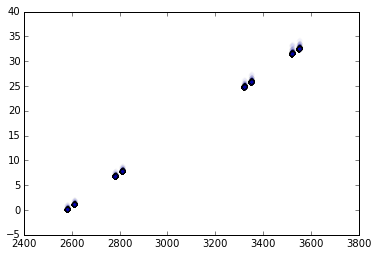

In [263]:
plt.scatter(X[:, 0], y, alpha=0.01)
plt.show()

In [264]:
len(X)

23748

In [265]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [266]:
from sklearn.ensemble import RandomForestRegressor

reg1 = RandomForestRegressor(n_estimators=100, max_depth=None)
reg1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [267]:
print 'Train score:', reg1.score(X_train, y_train)
print 'Test score:', reg1.score(X_test, y_test)

Train score: 0.9999794235
Test score: 0.999910503823


In [268]:
y_pred = reg1.predict(X_test)

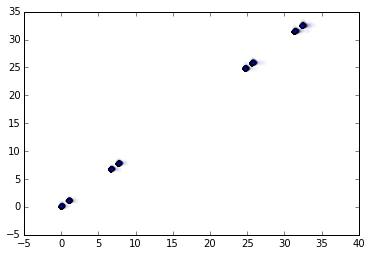

In [269]:
plt.scatter(y_test, y_pred, alpha=0.01)
plt.show()

MAE: 0.0561228717179


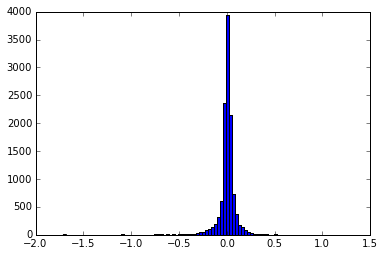

In [270]:
print 'MAE:', numpy.abs(y_pred - y_test).mean()
plt.hist(y_pred - y_test, bins=100)
plt.show()

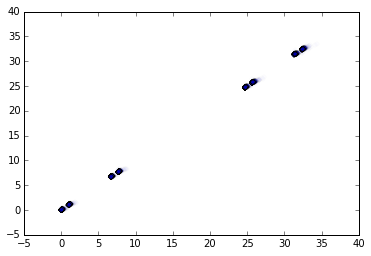

In [271]:
plt.scatter(y_train, reg1.predict(X_train), alpha=0.01)
plt.show()

MAE: 0.0282467187518


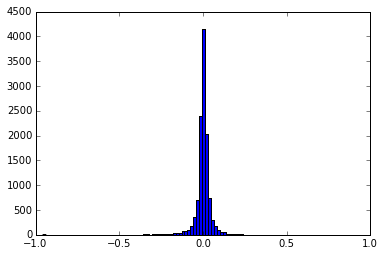

In [272]:
print 'MAE:', numpy.abs(reg1.predict(X_train) - y_train).mean()
plt.hist(reg1.predict(X_train) - y_train, bins=100)
plt.show()

# Regression

In [239]:
X = data[['Wz1', 'Wy1', 'Time']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)].values
y = data[['dist2Wire']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)].values[:, 0]

In [273]:
Xs = []
ys = []

for event_id in numpy.unique(data.EventID.values):
    
    X_event = data[['Wz1', 'Wy1', 'Time']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)*(data.EventID == event_id)]
    X_event['DiffTime'] = reg1.predict(X_event[['Wz1', 'Wy1']].values)
    
    y_event = data[['dist2Wire']][(data.ViewNb != 1)*(data.ViewNb != 2)*(data.Label >=0)*(data.EventID == event_id)].values[:, 0]
    
    Xs.append(X_event.values)
    ys.append(y_event)

In [274]:
X = numpy.concatenate(tuple(Xs), axis=0)
y = numpy.concatenate(tuple(ys), axis=0)

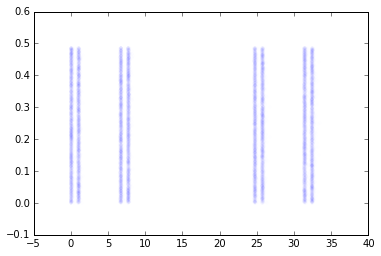

In [275]:
plt.scatter(X[:, 3], y, alpha=0.005)
plt.show()

In [276]:
len(X)

23748

In [277]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [285]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, max_depth=None)
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [286]:
print 'Train score:', reg.score(X_train, y_train)
print 'Test score:', reg.score(X_test, y_test)

Train score: 0.843693141993
Test score: -0.168596760776


In [287]:
y_pred = reg.predict(X_test)

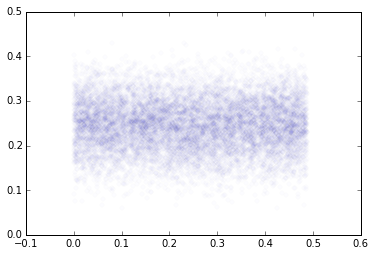

In [288]:
plt.scatter(y_test, y_pred, alpha=0.01)
plt.show()

MAE: 0.129666921147


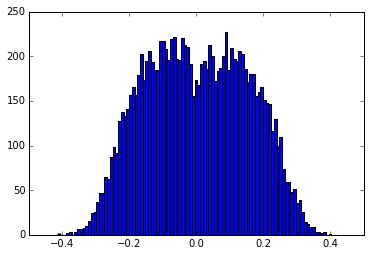

In [289]:
print 'MAE:', numpy.abs(y_pred - y_test).mean()
plt.hist(y_pred - y_test, bins=100)
plt.show()

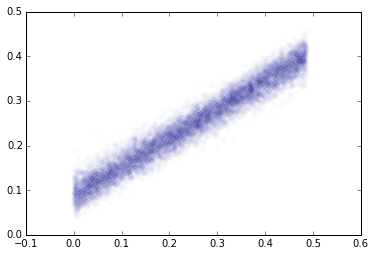

In [290]:
plt.scatter(y_train, reg.predict(X_train), alpha=0.01)
plt.show()

MAE: 0.047034545411


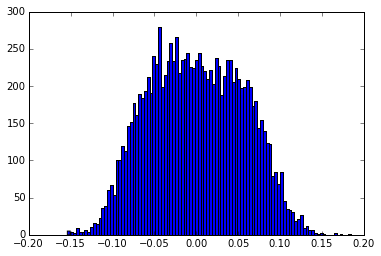

In [291]:
print 'MAE:', numpy.abs(reg.predict(X_train) - y_train).mean()
plt.hist(reg.predict(X_train) - y_train, bins=100)
plt.show()